<div style="text-align: center;">
    <b>Implementing U-net from Scratch ( O Ronneberger., et al. ) to segment UAV captured crop images into Crop / Weed Classes</b>
    
    ( github @aneesh-sathe ) 
</div>



In [2]:
# importing relevant libraries
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from random import random
%matplotlib inline

import torch
import torch.nn as nn
import torchvision
from torchvision.transforms import ToPILImage
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
from torchinfo import summary

import os
import warnings 
warnings.filterwarnings('ignore')

In [2]:
torch.__version__

'2.0.0'

In [6]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
SPLIT = 0.7
LR = 3e-4
PATH = '/Users/aneeshsathe/Desktop/u-net'

## Loading Custom Dataset

In [3]:
class UAVDataset(Dataset):
    def __init__(self, img_dir, mask_dir):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.images = sorted(os.listdir(img_dir))
        self.masks = sorted(os.listdir(mask_dir))
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        img_path = os.path.join(self.img_dir, self.images[index])
        mask_path = os.path.join(self.mask_dir, self.masks[index])
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("RGB") # multi-channel segmentation
        
        # using random library to ensure image and mask pairs have the same transformations
        
        if random() > 0.5:
            image = TF.hflip(image)
            mask = TF.hflip(mask)

        if random() > 0.5:
            image = TF.vflip(image)
            mask = TF.vflip(mask)
            
        if random() > 0.8:
            image = TF.rotate(image, 30)
            mask = TF.rotate(mask, 30)

        image = TF.to_tensor(image)
        mask = TF.to_tensor(mask)
        return image, mask

In [4]:
os.getcwd()

'/Users/aneeshsathe/Desktop/u-net'

In [5]:
os.makedirs('/kaggle/working/saved_model', exist_ok = True) # create library to store saved models

In [9]:
img_dir = PATH + '/extracted_data/image'
mask_dir = PATH + '/extracted_data/mask'
save_model_path = PATH + '/saved_model/model.pth'

In [10]:
img_dir, mask_dir, save_model_path

('/Users/aneeshsathe/Desktop/u-net/extracted_data/image',
 '/Users/aneeshsathe/Desktop/u-net/extracted_data/mask',
 '/Users/aneeshsathe/Desktop/u-net/saved_model/model.pth')

In [11]:
data = UAVDataset(img_dir = img_dir, mask_dir = mask_dir)

In [12]:
data.__len__()

215

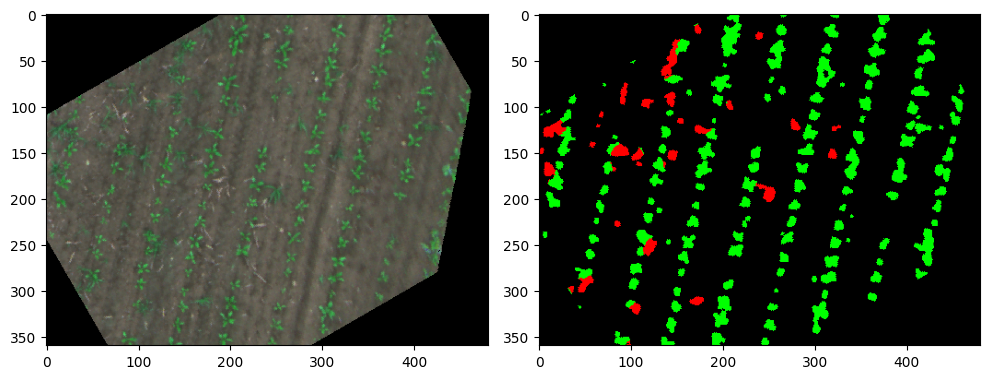

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))
image, mask = data[8]
ax[0].imshow(image.permute(1,2,0))
ax[1].imshow(mask.permute(1,2,0))
plt.tight_layout()

In [14]:
mask.shape

torch.Size([3, 360, 480])

In [15]:
image.shape

torch.Size([3, 360, 480])

In [16]:
train_size = int(len(data)*SPLIT)
test_size = len(data) - train_size

trainData, testData = random_split(data, [train_size, test_size])

In [17]:
len(trainData), len(testData)

(150, 65)

In [18]:
trainDL = DataLoader(trainData, batch_size = 16, shuffle = True)
testDL = DataLoader(testData, batch_size = 16, shuffle = True)

In [19]:
len(trainDL), len(testDL)

(10, 5)

In [20]:
for batch in trainDL:
    img, mask = batch
    print(img.size())
    break

torch.Size([16, 3, 360, 480])


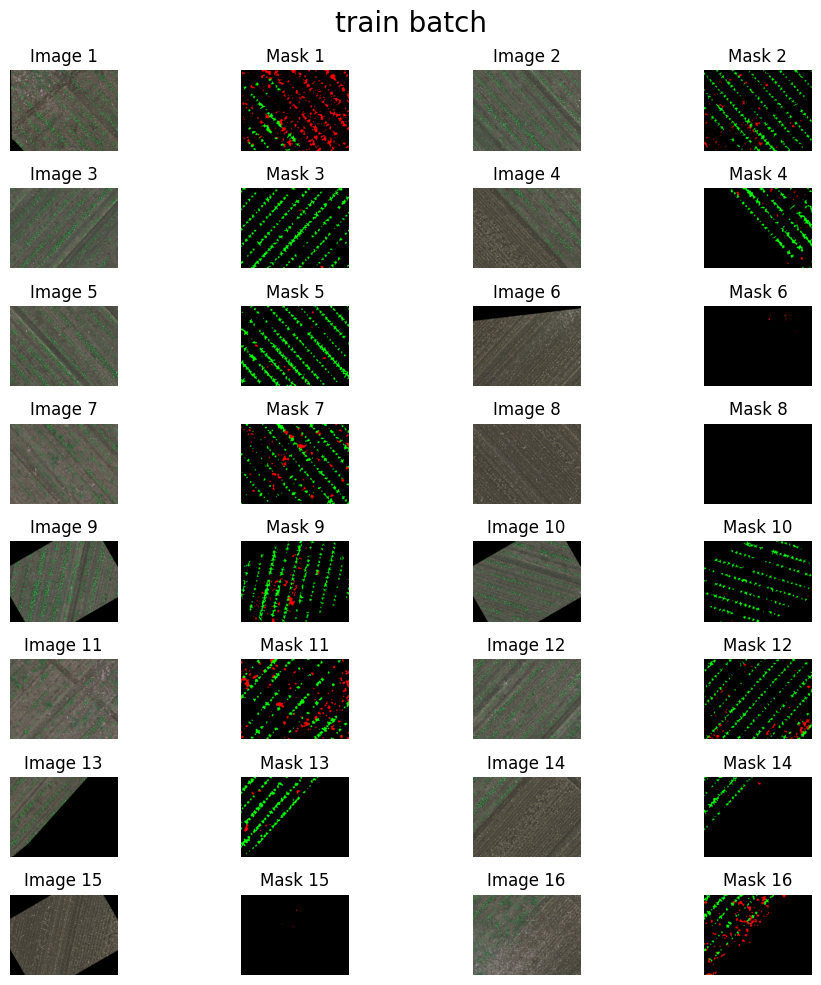

In [21]:
# plot image, mask pairs of the first training batch
for batch_idx, (images, masks) in enumerate(trainDL):
    if batch_idx == 0:
        fig, axs = plt.subplots(8, 4, figsize=(10,10))
        axs = axs.flatten()
        j = 0
        for i in range(16):
            img_np = TF.to_pil_image(images[i])
            mask_np = TF.to_pil_image(masks[i])

            # Plot the image
            axs[j].imshow(img_np)
            axs[j].axis('off')
            axs[j].set_title(f'Image {i+1}')

            # Plot the corresponding mask
            axs[j+1].imshow(mask_np, cmap='gray')
            axs[j+1].axis('off')
            axs[j+1].set_title(f'Mask {i+1}')
            j += 2

        plt.suptitle('train batch', size = 20)
        plt.tight_layout()

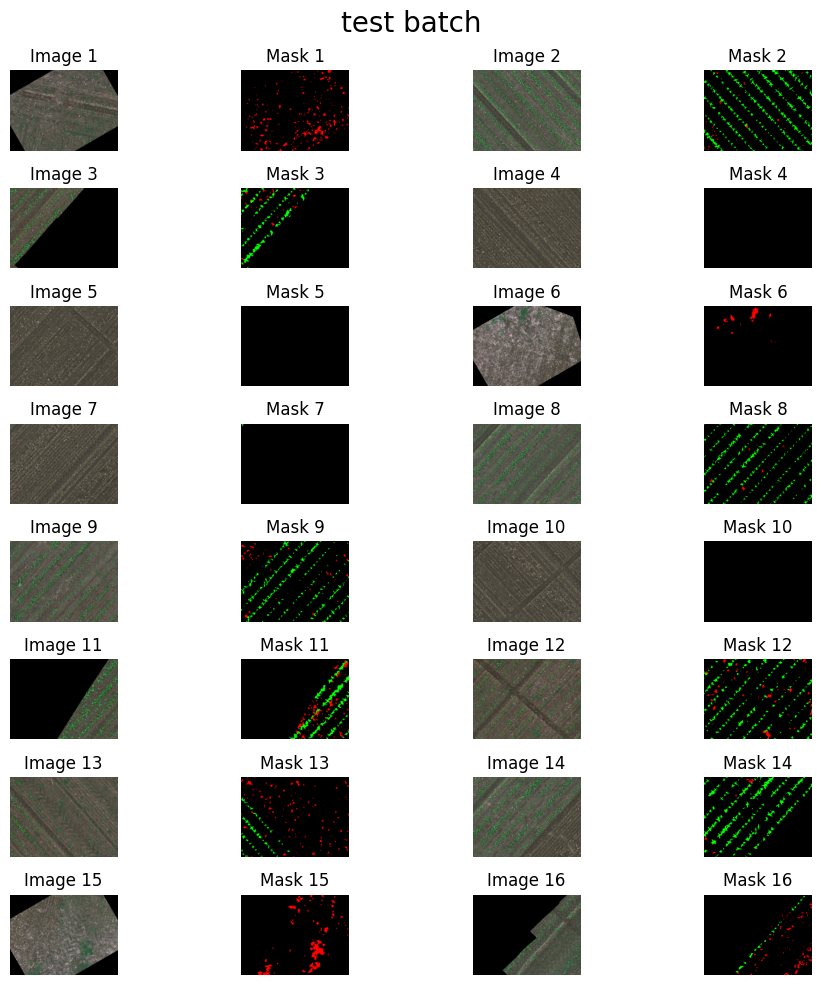

In [22]:
# plot image, mask pairs of the first test batch
for batch_idx, (images, masks) in enumerate(testDL):
    
    if batch_idx == 0:

        fig, axs = plt.subplots(8, 4, figsize=(10, 10))
        axs = axs.flatten()
        j=0
        for i in range(16):
            img_np = TF.to_pil_image(images[i])
            mask_np = TF.to_pil_image(masks[i])

            # Plot the image
            axs[j].imshow(img_np)
            axs[j].axis('off')
            axs[j].set_title(f'Image {i+1}')

            # Plot the corresponding mask
            axs[j+1].imshow(mask_np, cmap='gray')
            axs[j+1].axis('off')
            axs[j+1].set_title(f'Mask {i+1}')
            j += 2

        plt.suptitle('test batch', size = 20)
        plt.tight_layout()

## UNET Architecture from Scratch

In [23]:
class doubleConvolution(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(doubleConvolution, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        x = self.conv(x)
        return x

In [24]:
class UNet(nn.Module):
    def __init__(self, in_channels = 3, out_channels = 3, features = [64, 128, 256, 512]):
        super(UNet, self).__init__()
        self.up_conv = nn.ModuleList()
        self.down_conv = nn.ModuleList()
        self.pool = nn.MaxPool2d(stride = 2, kernel_size = 2)
        
        for feature in features:
            self.down_conv.append(doubleConvolution(in_channels, feature))
            in_channels = feature
        
        for feature in reversed(features):
            self.up_conv.append(nn.ConvTranspose2d(feature*2, feature, kernel_size = 2, stride = 2))
            self.up_conv.append(doubleConvolution(feature*2, feature))
        
        self.bottomConv = doubleConvolution(features[-1], features[-1]*2)
        
        self.lastConv = nn.Conv2d(features[0], out_channels, kernel_size = 1)
        
    def forward(self, x):
        skip_connections = []
        for down in self.down_conv:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottomConv(x)
        skip_connections = skip_connections[::-1]

        for i in range(0, len(self.up_conv), 2):
            x = self.up_conv[i](x)
            skip_connection = skip_connections[i//2]
            if x.shape != skip_connection.shape:
                x = TF.resize(x, size = skip_connection.shape[2:])
            concat = torch.cat((skip_connection, x), dim = 1)
            x = self.up_conv[i+1](concat)

        x = self.lastConv(x)
        return x
            

In [22]:
# ensure predicted mask & actual mask have equal dimensions
for batch in trainDL:
    img, mask = batch
    break
model = UNet()
x = img[0].unsqueeze(0)
pred = model(x)
assert(pred.shape == x.shape)
print(x.shape)
print(pred.shape)

torch.Size([1, 3, 360, 480])
torch.Size([1, 3, 360, 480])


In [25]:
model = UNet()
loss_criteria = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [26]:
model.load_state_dict(torch.load(save_model_path))

<All keys matched successfully>

In [47]:
summary(model, [16, 3, 360, 480])

Layer (type:depth-idx)                   Output Shape              Param #
UNet                                     [16, 3, 360, 480]         --
├─ModuleList: 1-7                        --                        (recursive)
│    └─doubleConvolution: 2-1            [16, 64, 360, 480]        --
│    │    └─Sequential: 3-1              [16, 64, 360, 480]        38,848
├─MaxPool2d: 1-2                         [16, 64, 180, 240]        --
├─ModuleList: 1-7                        --                        (recursive)
│    └─doubleConvolution: 2-2            [16, 128, 180, 240]       --
│    │    └─Sequential: 3-2              [16, 128, 180, 240]       221,696
├─MaxPool2d: 1-4                         [16, 128, 90, 120]        --
├─ModuleList: 1-7                        --                        (recursive)
│    └─doubleConvolution: 2-3            [16, 256, 90, 120]        --
│    │    └─Sequential: 3-3              [16, 256, 90, 120]        885,760
├─MaxPool2d: 1-6                         [16

## Model Training

In [26]:
def train_loop(epochs, model, trainDL, testDL, optimizer, loss_criteria):
    trainLossCount = []
    testLossCount = []
    best_test_loss = 10000000
    for epoch in range(epochs):
        train_loss = 0
        test_loss = 0

        for batch_idx, (img, mask) in enumerate(trainDL):
            #print(f"Train Batch: {batch_idx}")
            model.train()
            optimizer.zero_grad()
            pred = model(img)
            loss = loss_criteria(pred, mask)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(trainDL)  

        trainLossCount.append(train_loss)

        with torch.no_grad():
            for test_batch_idx, (test_img, test_mask) in enumerate(testDL):
                #print(f"Test Batch: {test_batch_idx}")
                test_pred = model(test_img)
                test_loss += loss_criteria(test_pred, test_mask)

            test_loss /= len(testDL)  

            testLossCount.append(test_loss)

        if epoch % 1 == 0:
            print(f"Epoch: {epoch}, Train Loss: {train_loss}, Test Loss: {test_loss}")
            if test_loss < best_test_loss:
                print(f"Saving the model. Previous Best Test Loss: {best_test_loss}, Current Test Loss: {test_loss}")
                best_test_loss = test_loss
                torch.save(model.state_dict(), os.path.join(save_model_path, 'model.pth'))
                
    return trainLossCount, testLossCount

In [27]:
trainLossCount, testLossCount = train_loop(15, model, trainDL, testDL, optimizer, loss_criteria)

Epoch: 0, Train Loss: 0.0741027481853962, Test Loss: 0.0707119032740593
Saving the model. Previous Best Test Loss: 10000000, Current Test Loss: 0.0707119032740593
Epoch: 1, Train Loss: 0.06604452282190323, Test Loss: 0.06126107648015022
Saving the model. Previous Best Test Loss: 0.0707119032740593, Current Test Loss: 0.06126107648015022
Epoch: 2, Train Loss: 0.061728890240192416, Test Loss: 0.05680636316537857
Saving the model. Previous Best Test Loss: 0.06126107648015022, Current Test Loss: 0.05680636316537857
Epoch: 3, Train Loss: 0.05709053240716457, Test Loss: 0.053416550159454346
Saving the model. Previous Best Test Loss: 0.05680636316537857, Current Test Loss: 0.053416550159454346
Epoch: 4, Train Loss: 0.053837281093001364, Test Loss: 0.053284741938114166
Saving the model. Previous Best Test Loss: 0.053416550159454346, Current Test Loss: 0.053284741938114166
Epoch: 5, Train Loss: 0.0508126251399517, Test Loss: 0.05147427320480347
Saving the model. Previous Best Test Loss: 0.05328

## Plotting Loss / Epoch Curve

In [29]:
# save loss metrics from training 
assert(len(trainLossCount) == len(testLossCount))
np.savez(os.path.join(save_model_path, 'lossCounts'), trainLossCount = trainLossCount, testLossCount = testLossCount)

In [32]:
load_loss_path = PATH + '/saved_model/'
losses = np.load(os.path.join(load_loss_path, 'lossCounts.npz'))

In [39]:
finalTrainLoss = losses['trainLossCount']
finalTestLoss = losses['testLossCount']

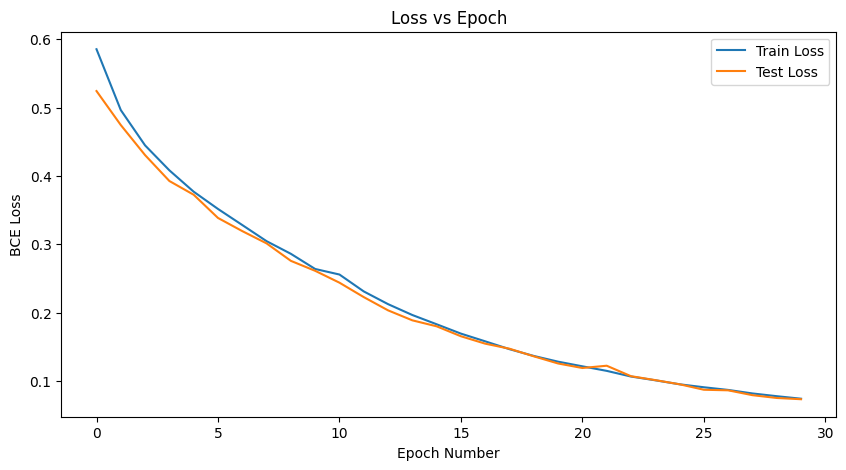

In [67]:
plt.figure(figsize=(10,5))
plt.plot([i for i in range(0, len(finalTrainLoss))], finalTrainLoss, label = 'Train Loss')
plt.plot([i for i in range(0, len(finalTestLoss))], finalTestLoss, label = 'Test Loss')
plt.xlabel('Epoch Number')
plt.ylabel('BCE Loss')
plt.title('Loss vs Epoch')
plt.legend()
plt.show()

## Model Inference

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

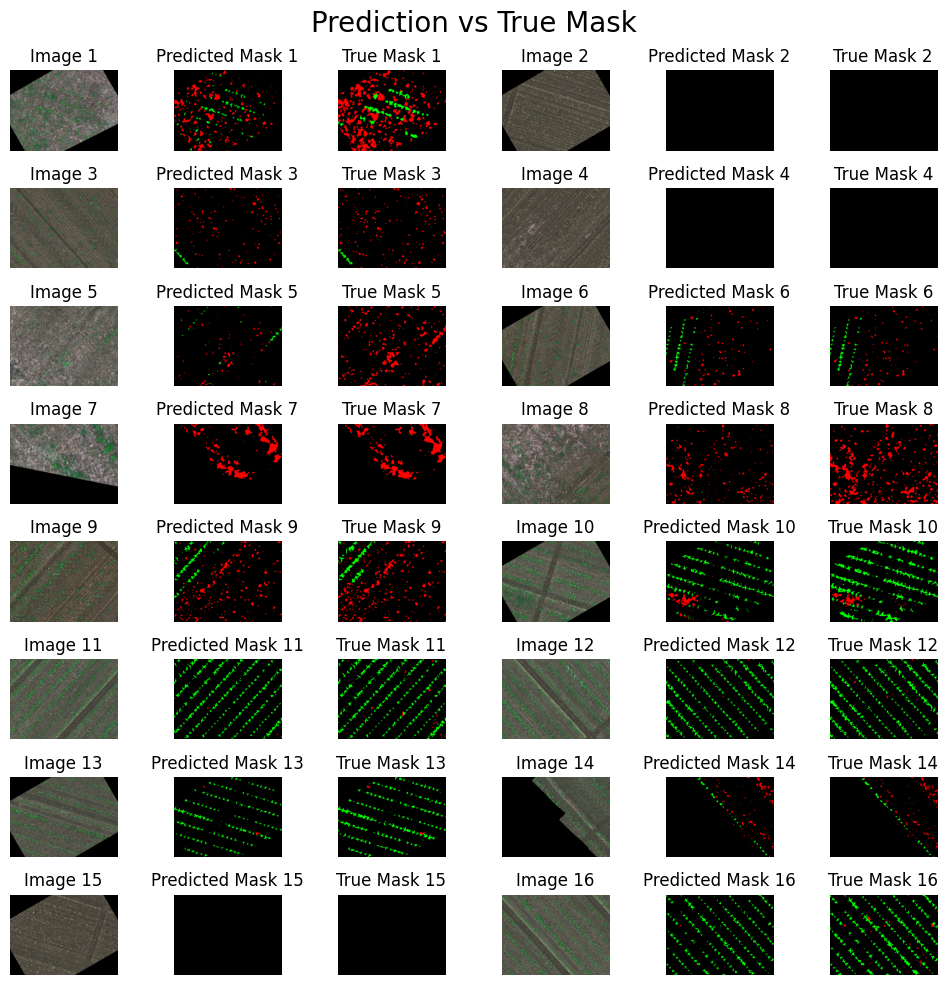

In [29]:
# plot test_batch with true / predicted masks
for batch_idx, (image, true_mask) in enumerate(testDL):
    if batch_idx == 0:
        fig, axs = plt.subplots(8, 6, figsize = (10,10))
        axs = axs.flatten()
        pred_mask = model(image)
        j = 0
        for i in range(16):
            
            # Plot the image
            axs[j].imshow(image[i].detach().numpy().transpose(1,2,0))
            axs[j].axis('off')
            axs[j].set_title(f'Image {i+1}')
            
            # Plot the predicted mask
            axs[j+1].imshow(pred_mask[i].detach().numpy().transpose(1,2,0))
            axs[j+1].axis('off')
            axs[j+1].set_title(f'Predicted Mask {i+1}')

            # Plot the corresponding mask
            axs[j+2].imshow(true_mask[i].detach().numpy().transpose(1,2,0))
            axs[j+2].axis('off')
            axs[j+2].set_title(f'True Mask {i+1}')
            j += 3

        plt.suptitle('Prediction vs True Mask', size = 20)
        plt.tight_layout()
        
        